# Исследование надёжности заёмщиков
**Цель проекта**
Заказчик проекта — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. 

**Имеющиееся данные:**  

Статистика о платежеспособности клиентов с указанием категорйных признаков (возраст, доход, семейное положение, наличие детей, уровень образования).

Результаты исследования будут учтены при построении модели кредитного скоринга.  

**Ход исследования**  
- предобработка данных
- категоризация данных
- опреление зависимости возврата кредита в срок от ключевых факторов:
    - наличие детей
    - семейное положение
    - уровень дохода
    - цель кредита

## Предобработка данных

In [1]:
import pandas as pd
import pymorphy2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
local_path = './data.csv'
server_path = '/datasets/data.csv'
try:
    data = pd.read_csv(local_path)
except:
    data = pd.read_csv(server_path)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [4]:
display(data.head(10))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [5]:
data.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

**Вывод**

Всего в таблице 12 столбцов и 21525 строк. Пропуски значений (NaN) есть в столбцах "days_employed" и "total_income".  
    
Названия столбцов корректны:  
- в них отсутствуют лишние пробелы и кирилические символы  
- в качестве разделителя слов использовано подчеркивание (_).  

Тип данных в колонке "days_employed" - float64 (вещественный), значения которые в нем хранятся (общий трудовой стаж в днях) подразумевают целочисленный тип данных (int64).  
В столбце 'dob_years' (возраст клиента в годах) есть значение 0 для 101 строки.  
Столбец "children" содержит отрицательное значение в 47 строках.

### Обработка пропусков

In [6]:
for col in data.columns:
    print(col, len(data[col].unique()))

children 8
days_employed 19352
dob_years 58
education 15
education_id 5
family_status 5
family_status_id 5
gender 3
income_type 8
debt 2
total_income 19352
purpose 38


In [7]:
data['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

**Вывод**

Количество значений в столбце "education_id" меньше чем в "education", следовательно есть дубликаты которые обработаем позднее.  
В столбце 'gender' количество значений больше двух, следовательно есть ошибки в заполнении.   

In [8]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [9]:
data.fillna(value=0, inplace=True)

In [10]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

In [11]:
data['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

В столбце "children" присутствует значение 20 в 76 строках, что вызывает сомнение в корректности данных.  
Возможна ошибка оператора, однако проверить истинность этих данных возможным не представляется.

In [12]:
data.loc[data['children'] < 0, 'children'] = data['children'].abs()

In [13]:
data.loc[data['children'] < 0]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


**Вывод**

Пропущенные значения присутствуют в стоблцах "days_employed" и "total_income".

Причина появления пропуска - клиентами не предоставлена информация о трудовом стаже и размере дохода.  
Заполнить такие данные можно нулями, чтобы можно было группировать данные и производить арифметические операции с ними. 

Отрицательные значение столбца 'children' заменены на положительные значения. Это можно считать ошибкой оператора.  
    
В столбце 'gender' есть пропущенное значение "XNA", но т.к. аналитики в разрезе данного столбца заданием не предусмотрено, этим пропуском можно пренебречь.


### Замена типа данных

In [14]:
data = data.astype({'days_employed':'int64', 'total_income':'int64'})

**Вывод**

Для изменения типа данных в столбцах значений ('days_employed' и 'total_income') был использован метод astype().  

Для замены был передан целочисленный тип int64. 


### Обработка дубликатов

In [15]:
data.duplicated().sum()

54

In [16]:
data = data.drop_duplicates()

In [17]:
data.duplicated().sum()

0

In [18]:
data['education'].value_counts()

среднее                13705
высшее                  4710
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   273
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

In [19]:
data['education_lowcase'] = data['education'].str.lower()

In [20]:
data['education_lowcase'].value_counts()

среднее                15188
высшее                  5251
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education_lowcase, dtype: int64

**Вывод**

Для выявления явных дубликатов использован метод .duplicated(), для их удаления .drop_duplicates().
    
Для удаления неявных дубликатов в колонке "education", связанных с различными написаниями (разные регистры в строках, начальные строчные буквы и т.д.) был использован метод str.lower().  
Это позволило привести все строковые данные к одному регистру.  
Причиной появления таких дубликатов можно считать небрежность исполнителя и/или отсутствием четкого регламента по заполнению этого поля в первичном документе. 
Также к такому заполнению могло привести отсутствие проверки данных на допустимость значений (выбор из предложенного) при проектировании таблицы БД.


### Лемматизация

In [21]:
morph = pymorphy2.MorphAnalyzer()
def lemmas_purpose(row):
    lemmas = [morph.parse(x)[0].normal_form for x in row['purpose'].split(' ')]
    if 'свадьба' in lemmas:
        return 'свадьба'
    elif 'недвижимость' in lemmas or 'жильё' in lemmas:
        return 'недвижимость' 
    elif 'автомобиль' in lemmas:
        return 'автомобиль' 
    elif 'образование' in lemmas:
        return 'образование' 
    
data['group_purpose'] = data.apply(lemmas_purpose, axis=1)

In [22]:
data['group_purpose'].value_counts(dropna=False)

недвижимость    10814
автомобиль       4308
образование      4014
свадьба          2335
Name: group_purpose, dtype: int64

**Вывод**

Лемматизация целей кредита (столбец 'purpose') проведена с помощью бибилиотеки pymystem3.  
    
Одновременно с лематизацией проведена категоризация этих данных по 4 категориям: свадьба, недвижимость, автомобиль, образование.  
Это реализовано при помощи собственной функции lemmas_purpose().  
С помощью метода apply() и функции lemmas_purpose() был создан и заполнен новый столбец с категорией цели кредита ('group_purpose').


### Категоризация данных

In [23]:
def group_children(row):
    row = row['children']
    if row == 0:
        return 'без детей'
    elif 1 <= row <= 2:
        return '1-2 ребенка' 
    else:
        return 'многодетный'

data['group_children'] = data.apply(group_children, axis=1)   

In [24]:
def group_income(row):
    row = row['total_income']
    if row <= data['total_income'].median():
        return 'доход ниже медианного'
    else:
        return 'доход выше медианного'
data['group_income'] = data.apply(group_income, axis=1)

In [25]:
purpose_grouped = data.groupby('group_purpose')['purpose'].count()
purpose_grouped

group_purpose
автомобиль       4308
недвижимость    10814
образование      4014
свадьба          2335
Name: purpose, dtype: int64

In [26]:
children_grouped = data.groupby('group_children')['children'].count()
children_grouped

group_children
1-2 ребенка     6908
без детей      14107
многодетный      456
Name: children, dtype: int64

In [27]:
family_status_grouped = data.groupby('family_status')['family_status_id'].count()
family_status_grouped

family_status
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
гражданский брак          4163
женат / замужем          12344
Name: family_status_id, dtype: int64

In [28]:
income_grouped = data.groupby('group_income')['total_income'].count()
income_grouped

group_income
доход выше медианного    10735
доход ниже медианного    10736
Name: total_income, dtype: int64

**Вывод**

Для ответа на вопросы о зависимости возврата кредита в срок от факторов: наличия детей, семейного положения, уровня дохода и цели кредита была проведена категоризация.  
    
Категория дети состоит из 3 подгрупп:
* без детей
* 1-2 ребенка
* многодетный
    
    
Такое деление позволит ответить на вопрос "Есть ли зависимость между наличием детей и возвратом кредита в срок?" с дополнительной детализацией кроме есть/нет дети, но и с числом детей.

Категория семейное положение создана на основе имеющихся данных в датасете.    
    
Категория уровень дохода создана на основе медианного дохода всех заемщиков, группировка проведена по уровню выше/ниже медианного значения.
    
Категория цель кредита разбита по 4 категориям: свадьба, недвижимость, автомобиль, образование.  


## Определение зависимости возврата кредита в срок от факторов наличия детей, семейного положения и целей кредитования

In [29]:
# напишем функцию с помощью которой сгруппируем исходные данные по анализируемым факторам
def pivot_data(df, fact):
    index=[fact, 'debt', ]
    pdf = df.pivot_table(
        index = index,
        values = 'children',
        aggfunc='count'        
    ).rename(columns={'children':'number'})
    
    pdf['part'] = (pdf['number'] / data.groupby(fact).count().iloc[:,0] * 100).round(2)
    
    return pdf.reset_index()


### Зависимость между наличием детей и возвратом кредита в срок

In [30]:
pivot_child = pivot_data(data, 'group_children')
pivot_child

,group_children,debt,number,part
0,1-2 ребенка,0,6269,90.75
1,1-2 ребенка,1,639,9.25
2,без детей,0,13044,92.46
3,без детей,1,1063,7.54
4,многодетный,0,417,91.45
5,многодетный,1,39,8.55


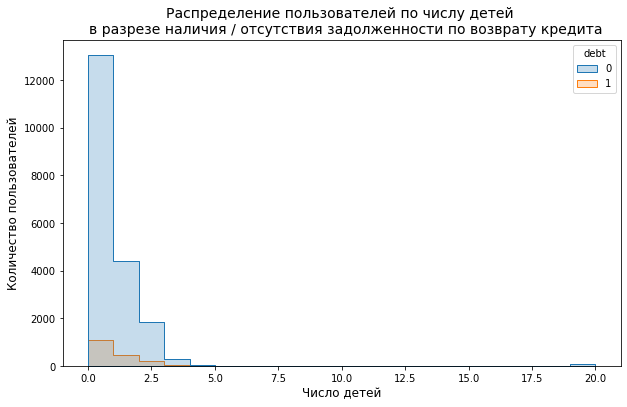

In [31]:
plt.figure(figsize=(10,6))

sns.histplot(
    data = data,
    x='children',
    hue='debt',
    bins=20,
    element='step',
    legend=True,

)
plt.xlabel('Число детей', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.title('Распределение пользователей по числу детей \n  \
в разрезе наличия / отсутствия задолженности по возврату кредита',
         fontsize=14)
plt.show()

**Вывод**

На основании полученных данных наибольшая доля клиентов, имевших задолженность по возврату кредита, приходится на группу "1-2 ребенка", группа "многодетный" на втором месте.  
    
Можно сделать вывод, что наличие детей увеличивает риск возникновения задолженности по кредиту.


### Зависимость между семейным положением и возвратом кредита в срок

In [32]:
pivot_status = pivot_data(data, 'family_status')
pivot_status

,family_status,debt,number,part
0,Не женат / не замужем,0,2536,90.25
1,Не женат / не замужем,1,274,9.75
2,в разводе,0,1110,92.89
3,в разводе,1,85,7.11
4,вдовец / вдова,0,896,93.43
5,вдовец / вдова,1,63,6.57
6,гражданский брак,0,3775,90.68
7,гражданский брак,1,388,9.32
8,женат / замужем,0,11413,92.46
9,женат / замужем,1,931,7.54


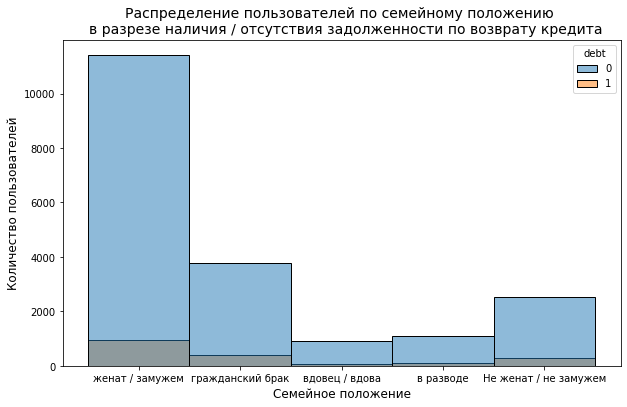

In [33]:
plt.figure(figsize=(10,6))

sns.histplot(
    data = data,
    x='family_status',
    hue='debt',
    bins=20,
    element='bars',
    legend=True,

)
plt.xlabel('Семейное положение', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.title('Распределение пользователей по семейному положению \n  \
в разрезе наличия / отсутствия задолженности по возврату кредита',
         fontsize=14)
plt.show()

**Вывод**

Если анализировать риск образования задолженности по кредиту в разрезе групп, основанных на семейном положении, то наибольший удельный вес приходится на группу "Не женат / не замужем".  
    
Группа с наименьшим риском - "вдовец / вдова".


### Зависимость между уровнем дохода и возвратом кредита в срок

In [34]:
pivot_income = pivot_data(data, 'group_income')
pivot_income

,group_income,debt,number,part
0,доход выше медианного,0,9868,91.92
1,доход выше медианного,1,867,8.08
2,доход ниже медианного,0,9862,91.86
3,доход ниже медианного,1,874,8.14


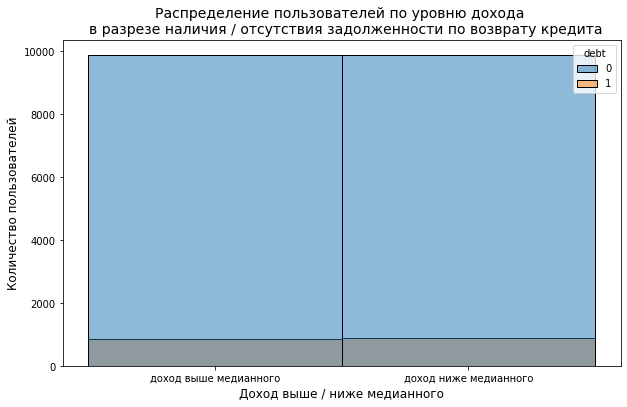

In [35]:
plt.figure(figsize=(10,6))

sns.histplot(
    data = data,
    x='group_income',
    hue='debt',
    bins=20,
    element='bars',
    legend=True,

)
plt.xlabel('Доход выше / ниже медианного', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.title('Распределение пользователей по уровню дохода \n  \
в разрезе наличия / отсутствия задолженности по возврату кредита',
         fontsize=14)
plt.show()

**Вывод**

В разрезе уровня дохода относительно медианного значения (выше/ниже) риск возникновения задолженности по кредиту не имеет существенного различия. Доля таких клиентов в обеих группах на уровне 8%.


### Зависимость цели кредита и его возврат в срок

In [36]:
pivot_purpose = data.pivot_table(index=['group_purpose', 'debt'], values='children',aggfunc='count')
pivot_purpose['part'] = (pivot_purpose['children'] / data.groupby('group_purpose')['children'].count() * 100).round(2)
pivot_purpose

children   part
group_purpose debt                 
автомобиль    0         3905  90.65
              1          403   9.35
недвижимость  0        10032  92.77
              1          782   7.23
образование   0         3644  90.78
              1          370   9.22
свадьба       0         2149  92.03
              1          186   7.97

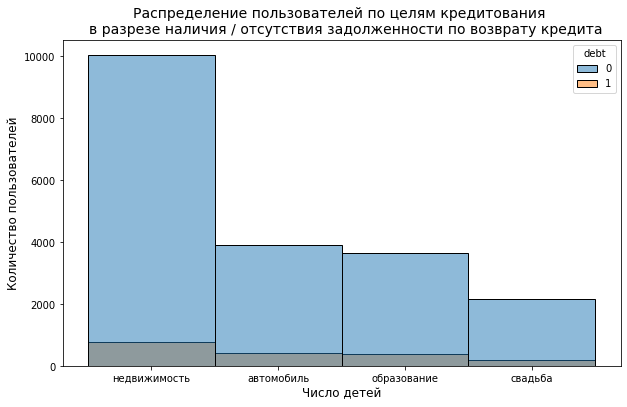

In [37]:
plt.figure(figsize=(10,6))

sns.histplot(
    data = data,
    x='group_purpose',
    hue='debt',
    bins=20,
    element='bars',
    legend=True,

)
plt.xlabel('Число детей', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.title('Распределение пользователей по целям кредитования \n  \
в разрезе наличия / отсутствия задолженности по возврату кредита',
         fontsize=14)
plt.show()

**Вывод**

В зависимости от цели кредита наибольшее число клиентов, допускавших задолженность по его погашению, относится к группе с целевым назначением кредита "автомобиль". 


## Шаг 4. Общий вывод

    
**Были проверены 4 гипотезы зависимости возврата кредита в срок.**
    
**Первая**: "Есть ли зависимость между наличием детей и возвратом кредита в срок?" подтвердилась полностью - наличие детей (не в зависимости от числа) увеличивает риск возникновения задолженности.
    
**Вторая**: "Есть ли зависимость между семейным положением и возвратом кредита в срок?" также подтвердилась - разброс доли клиентов допускавших задолженность в зависимости от группы составляет от 6,57% до 9,75%.

**Третья**: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?" не подтвердилась. Значительной зависимости от уровня дохода кредитора (в сравнении с медианным значением) не наблюдается.
       
**Четвертая:** "Как разные цели кредита влияют на его возврат в срок?" также нашла свое подтверждение. Наибольший риск возникновения задолженности имеют кредиты на приобретение автомобиля, наименьший - на приобретение недвижимости.
